This notebook is for development and testing purposes. 

All the code works but the sales data and PDF documents have to be placed in the right folders, which need to be created.
It is advised to not use it with the same folders as the Python script verson, as there may be inconsistencies with the
PDF metadata and the Chroma DB persisted data.

To easy testing and debugging, intermediate functions have not been removed but they are commented out. Also, functions
that were used in previous approaches have been left in the code but commented out to show the evolution of the code, as
explained in the documentation.

To-Do - Add title, basic info and docu

To-Do - Use something other than Pandas for dynamic dashboard-style data visualization

In [1]:
# !pip freeze > requirements.txt

In [2]:
# OS and system
import os
import openai
from dotenv import load_dotenv

# Data structures and metadata
import json
from pathlib import Path
from datetime import datetime

# Display formatting
from pprint import pprint

# Data visualization for sales data and chunk dsistributions for validation
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading and analysis
import pandas as pd

# Tool for the AI agent to use
from langchain.tools import tool
from langchain.agents import initialize_agent, AgentType
# from agent.tools import describe_data

# PDF loading
from langchain.document_loaders import PyPDFLoader

# Text splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

# OpenAI embeddings
from langchain_openai.embeddings import OpenAIEmbeddings

# Vector store
# from langchain.vectorstores import Chroma
from langchain_community.vectorstores import Chroma

# Chatbot and LangChain templates
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
# from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.memory import ConversationBufferMemory
from langchain.callbacks import StdOutCallbackHandler, OpenAICallbackHandler

In [3]:
# Load environment variables from .env file. Only for local installation. Not needed for SimpliLearnLab
load_dotenv(dotenv_path="/Users/scarbez-ai/Documents/Projects/_env/keys.env")
# load_dotenv(dotenv_path="/Users/scarbez-ai/Documents/Projects/Windsurf/AGS/keys.env")

# Access the secrets safely
openai.api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# print(openai.api_key)

In [5]:
# Utility function for displaying data structures in a more readable format

def pretty_print(data):
    """Nicely prints any Python data structure."""
    pprint(data, indent=2, width=100, compact=False)

### Catch and intercept generic greetings

In [6]:
# def check_greeting(user_input: str) -> bool:
#     """
#     Check if the user's input is a greeting, like 'hi', 'hello', etc.
#     Returns True if so, False otherwise.
#     """
#     greetings = ["hi", "hello", "hey", "good morning", "good afternoon", "good evening"]
#     normalized = user_input.strip().lower()
#     return any(normalized.startswith(greet) for greet in greetings)

In [7]:
# # Function to route to agent or conversational retrieval chain for improved outputs

# def route_query(user_input: str) -> str:
#     """
#     Simple heuristic-based router to decide if input goes to RAG or data agent.
#     Returns: "rag" or "agent"
#     """
#     input_lower = user_input.lower()

#     # Keywords suggesting RAG (business intelligence, strategy, BI concepts)
#     rag_keywords = [
#         "what is", "define", "explain", "difference between", 
#         "role of", "business intelligence", "bi", "ai", "olap", "oltp", "governance", "strategy", "maturity", "adoption"
#     ]

#     # Keywords suggesting BI metrics, sales, customer analysis
#     agent_keywords = [
#         "sales", "region", "product", "customer", "satisfaction", "age", "statistic", "segment", 
#         "summarize", "analyze", "performance", "metric", "trend"
#     ]

#     if any(kw in input_lower for kw in rag_keywords):
#         return "rag"
#     if any(kw in input_lower for kw in agent_keywords):
#         return "agent"

#     # Default to agent (conservative fallback)
#     return "agent"

In [8]:
# def wants_plot(user_input: str) -> bool:
#     """
#     Check if the user asks for a plot in their query.
#     Returns: True if input suggests a plot, False otherwise
#     """

#     # Keywords suggesting a plot
#     plot_keywords = [
#         "plot", "chart", "graph", "diagram", "visualization", "visualize", "visual", "display", "show", "illustrate"
#     ]

#     normalised = user_input.strip().lower()
#     return any(kw in normalised for kw in plot_keywords)

In [9]:
# Classify user input using LLM
def classify_input(user_input: str) -> str:
    """
    Classifies user input as:
    - 'bi_query': A Business Intelligence-related data question
    - 'sales_analysis': Request to perform sales data analysis
    - 'plot_request': Request to generate a visual or plot of the data
    - 'greeting': Social or polite greeting
    - 'off_topic': Unrelated to BI or sales data
    - 'unclear': Can't classify
    """
    prompt = f"""
    You are an assistant that classifies user input related to a business intelligence assistant that can analyze sales data and business documents.

    Classify each query as one of:
    - bi_query: Asking about business intelligence (e.g. ETL, KPIs), insights, stats, etc.
    - sales_analysis: Request to perform sales data analysis.
    - plot_request: Explicitly asking for charts or graphs.
    - greeting: A social greeting.
    - off_topic: Clearly not related to business, sales, or data.
    - unclear: Cannot be confidently categorized.

    Examples:

    User: "Hello, how are you?"
    Classification: greeting

    User: "What are the key components of a BI system?"
    Classification: bi_query

    User: "Explain the difference between OLAP and OLTP."
    Classification: bi_query

    User: "What is ETL in business intelligence?"
    Classification: bi_query

    User: "List some benefits of implementing a BI platform."
    Classification: bi_query

    User: "How can AI enable business model innovation?"
    Classification: bi_query

    User: "What challenges exist in adopting AI for business model innovation?"
    Classification: bi_query

    User: "Give examples of AI-driven value propositions."
    Classification: bi_query

    User: "How is IoT data used in time-series forecasting?"
    Classification: bi_query

    User: "Describe a machine learning pipeline for predicting air quality using IoT."
    Classification: bi_query

    User: "What are the limitations of IoT data for ML predictions?"
    Classification: bi_query

    User: "How did Walmart use big data analytics to improve operations?"
    Classification: bi_query

    User: "What technologies did Walmart adopt to handle large-scale sales data?"
    Classification: bi_query

    User: "Summarize Walmart’s approach to customer segmentation."
    Classification: bi_query

    User: "Compare the benefits of business intelligence with those of big data analytics."
    Classification: bi_query

    User: "What role does data governance play in BI and AI adoption?"
    Classification: bi_query

    User: "Explain how time-series prediction techniques could integrate with a BI dashboard."
    Classification: bi_query

    User: "Analyze sales data by month."
    Classification: sales_analysis

    User: "Analyze sales data by quarter."
    Classification: sales_analysis

    User: "Analyze sales data by year."
    Classification: sales_analysis

    User: "Analyze sales data by product and region."
    Classification: sales_analysis

    User: "Analyze sales data by customer segment."
    Classification: sales_analysis

    User: "Provide statistical metrics of the sales data."
    Classification: sales_analysis

    User: "Do statistical analysis on the sales data."
    Classification: sales_analysis

    User: "Can you show me a graph of sales this month?"
    Classification: plot_request

    User: "Analyze sales data by month and plot the results in a graph."
    Classification: plot_request

    User: "Analyze sales data by quarter and plot the results in a graph."
    Classification: plot_request

    User: "Analyze sales data by year and plot the results in a graph."
    Classification: plot_request

    User: "What’s your favorite color?"
    Classification: off_topic

    User: "Sales"
    Classification: unclear

    User: "{user_input}"
    Classification:
    """.strip()
    try:
        classification = llm.predict(prompt).strip().lower()
        return classification
    except Exception as e:
        print("Classification error:", e)
        return "unclear"

## RAG-Related Functions

In [10]:
# Auxiliary function to check chunk sizes and distribution to see if merging is needed

def disp_chunk_distr(chunk_list):
    # Get chunk sizes (number of characters)
    chunk_sizes = [len(chunk.page_content) for chunk in chunk_list]

    # Basic statistics
    print(f"Number of chunks: {len(chunk_sizes)}")
    print(f"Mean chunk size: {sum(chunk_sizes)/len(chunk_sizes):.2f}")
    print(f"Min chunk size: {min(chunk_sizes)}")
    print(f"Max chunk size: {max(chunk_sizes)}")

    # Plot histogram
    plt.figure(figsize=(10, 5))
    plt.hist(chunk_sizes, bins=30, color='skyblue', edgecolor='black')
    plt.title("Distribution of Chunk Sizes")
    plt.xlabel("Chunk Size (characters)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [11]:
# Load the PDF and split into pages
# To-Do - Try PyPDF2 or other that might be better
# To-Do - Research and implement PDF data extractors and/or parsers that can use:
#   - the information in tables
#   - the information in diagrams
#   - textual image data
#   - non-textual image data

def load_docs(docs_paths):
    # pdf_list = [
    #     "Data/BI PDFs/AI-Driven-Business-Model-Innovation.pdf", 
    #     "Data/BI PDFs/Business-Intelligence-Concepts-and-Approaches.pdf", 
    #     "Data/BI PDFs/Time-Series-Data-Prediction-Using-IoT-and-ML.pdf", 
    #     "Data/BI PDFs/Walmart_s-Sales-Data-Analysis.pdf"
    #     ]

    docs_data = []

    pretty_print(docs_paths)
    print(len(docs_paths))

    for i, path in enumerate(docs_paths):
        loader = PyPDFLoader(str(path))
        docs_data.append(loader.load())

    return docs_data

In [12]:
# Apply document contemt type metadata for custom chunking

def classify_docs(pdf_data):
    for doc in range(len(pdf_data)):
        for page in pdf_data[doc]:
            print(f"Doc : {doc}")
            # To-Do - Add catch all / exceptions
            match doc:
                case 0:
                    print(f"Doc : {doc} - academic")
                    page.metadata["doc_type"] = "academic"
                case 1:
                    print(f"Doc : {doc} - academic")
                    page.metadata["doc_type"] = "academic"
                case 2:
                    print(f"Doc : {doc} - academic")
                    page.metadata["doc_type"] = "academic"
                case 3:
                    print(f"Doc : {doc} - business_case")
                    page.metadata["doc_type"] = "business_case"

    return pdf_data

In [13]:
# Chunking
# Different chunks depending on document contenst type: scientific smaller chunks, more overlap; business, larger chunks, less overlap
# To-Do - Add auto-optimization capabilities

# To-Do - Add catch all / exceptions

def chunk_docs(docs_data):
    docs_chunks = []

    for doc in docs_data:
        for doc_page in doc:
            doc_type = doc_page.metadata.get("doc_type", "business")

            match doc_type:
                case "scientific":
                    text_splitter = RecursiveCharacterTextSplitter(
                        chunk_size= 500,
                        chunk_overlap=100 # 1/5 of the chunk size
                )
                case "business":
                    text_splitter = RecursiveCharacterTextSplitter(
                        chunk_size= 1000,
                        chunk_overlap=200 # 1/5 of the chunk size
                )
                case _:
                    text_splitter = RecursiveCharacterTextSplitter(
                        chunk_size=800,
                        chunk_overlap=160
                    )
        
            docs_chunks.extend(text_splitter.split_documents([doc_page]))

    return docs_chunks

In [14]:
def optimize_chunks(docs_chunks):
    final_chunks = []
    buffer = ""
    buffer_meta = None  # Optional: to keep first or combined metadata

    for chunk in docs_chunks:
        text = chunk.page_content.strip()
        if len(text) < 300:
            if not buffer:
                buffer = text
                buffer_meta = chunk.metadata  # start new buffer
            else:
                buffer += " " + text
                # Optionally, update metadata to combine source info here
            # Only create chunk when buffer is big enough
            if len(buffer) >= 500:
                final_chunks.append(Document(page_content=buffer.strip(), metadata=buffer_meta))
                buffer = ""
                buffer_meta = None
        else:
            # If there is something in the buffer, flush it before appending the large chunk
            if buffer:
                final_chunks.append(Document(page_content=buffer.strip(), metadata=buffer_meta))
                buffer = ""
                buffer_meta = None
            final_chunks.append(chunk)

    # If any text remains in the buffer, flush it as a final chunk
    if buffer:
        final_chunks.append(Document(page_content=buffer.strip(), metadata=buffer_meta))

    return final_chunks

In [15]:
# Functions for rebuilding the vector stores if documents have changed

# To-Do - Move to top maybe
# To-Do - Update for .py version
DOCS_DIR = Path("Data/BI PDFs/")
META_FILE = DOCS_DIR / "metadata.json"

def get_docs_paths():
    return [f for f in DOCS_DIR.glob("*.pdf")]

def get_file_info(file_path):
    stat = os.stat(file_path)
    return {
        "size": stat.st_size,
        "modified": datetime.fromtimestamp(stat.st_mtime).isoformat() # To-Do - Check is "added" would be better
    }

def needs_rebuild(docs_paths):
    if not META_FILE.exists():
        return True

    with open(META_FILE, "r") as f:
        old_meta = json.load(f)

    for file in docs_paths:
        info = get_file_info(file)
        name = file.name

        if name not in old_meta or old_meta[name] != info:
            return True

    return False

def save_metadata(docs_paths):
    current_meta = {
        f.name: get_file_info(f)
        for f in docs_paths
    }
    with open(META_FILE, "w") as f:
        json.dump(current_meta, f, indent=2)

def load_or_rebuild_vector_store():
    # Define embedding model
    embedding_model = OpenAIEmbeddings(model = "text-embedding-3-large") # Try larger model, 256 dimensions
    # embedding_model = OpenAIEmbeddings(model = "text-embedding-3-small") # Original, used in demos, 128 dimensions

    docs_paths = get_docs_paths()
    docs_chunks = []

    if needs_rebuild(docs_paths):
        print("🔁 Rebuilding vector store...")
        docs_data = load_docs(docs_paths)
        docs_data = classify_docs(docs_data)
        docs_chunks = chunk_docs(docs_data)
        docs_chunks = optimize_chunks(docs_chunks)
        save_metadata(docs_paths)
        vector_store = Chroma.from_documents(
            docs_chunks,
            embedding_model,
            persist_directory="db" # Needed for ConversationalRetrievalChain routing to work
        )
        vector_store.persist()
    else:
        print("✅ Loading existing vector store...")
        # Build vector store from split_doc using your embedding model
        vector_store = Chroma(persist_directory="db", embedding_function=embedding_model)

    return vector_store

In [16]:
# tmp_docs_list = get_docs_list()
# tmp_docs_list

# tmp_docs_data = load_docs(tmp_docs_list)
# classify_docs(tmp_docs_data)
# tmp_docs_chunks = chunk_docs(tmp_docs_data)
# tmp_docs_chunks

# print("Number of chunks:", len(tmp_docs_chunks))
# pretty_print(tmp_docs_chunks)

In [17]:
# disp_chunk_distr(tmp_docs_chunks)
# tmp_docs_chunks = optimize_chunks(tmp_docs_chunks)
# disp_chunk_distr(tmp_docs_chunks)

In [18]:
# tmp_vector_store = load_or_rebuild_vector_store()

## Sales data loading and Pandas analysis

In [19]:
# Data (sales CSV file) loading and analysis

class DataHandler:
    def __init__(self, csv_path: str):
        self.df = pd.read_csv(csv_path, parse_dates=["Date"])
        
        # Convert to categories for improved performance
        self.df["Product"] = self.df["Product"].astype("category")
        self.df["Region"] = self.df["Region"].astype("category")
        self.df["Customer_Gender"] = self.df["Customer_Gender"].astype("category")

        # Additional columns for more efficient analysis
        self.df["Year"] = self.df["Date"].dt.year
        self.df["Month"] = self.df["Date"].dt.month
        self.df["Weekday"] = self.df["Date"].dt.day_name()
    
    # Method for producing sales by time period, called by the agent tool
    def sales_by_time_period(self, period: str):
        """
        Aggregate sales total by time period.
        
        Parameters:
            period (str): 
                "ME" = month end
                "QE" = quarter end
                "YE" = year end
        Returns:
            pd.DataFrame: DataFrame with time period and aggregated sales
        """
        if period not in ["ME", "QE", "YE"]:
            raise ValueError("Invalid period. Use 'ME', 'QE', or 'YE'.")

        df_grouped = (
            self.df.set_index("Date")
            .resample(period)["Sales"]
            .sum()
            .reset_index()
            .rename(columns={"Date": "Period", "Sales": "Total Sales"})
        )

        return df_grouped

    # Nethod for producing sales by product and region, called by the agent tool
    def sales_by_product_region(self):
        """
        Returns a pivot table showing sales totals by product and region.
        """
        pivot = self.df.pivot_table(
            index="Product",
            columns="Region",
            values="Sales",
            aggfunc="sum"
        ).fillna(0)
        return pivot.to_dict() # Return dict to prevent issues in displaying the table format. Dict follows JSON format. The UI
        #  will convert it back to a table
    
    # Method for producing customer segmentation analysis, called by the agent tool
    def sales_by_cust_segment(self):
        """
        Segments customers by age group and gender, reporting total sales and average satisfaction.
        Returns a DataFrame as JSON for easy visualization.
        """
        # define age bins
        age_bins = [18, 25, 35, 45, 55, 65, 80]
        self.df["Age_Group"] = pd.cut(self.df["Customer_Age"], bins=age_bins, right=False)

        # group by
        segment = self.df.groupby(["Age_Group", "Customer_Gender"]).agg(
            Total_Sales=("Sales", "sum"),
            Average_Satisfaction=("Customer_Satisfaction", "mean")
        ).reset_index()

        return segment.to_dict(orient="records")

    # Method for producing statistical data, called by the agent tool
    def statistical_metrics(self):
        """
        Returns the pandas describe summary as string.
        """
        return self.df.describe().to_string()
    
    # Methods for data preparation for plotting results
    def get_monthly_sales_summary(self):
        """
        Returns a DataFrame with total sales by month for plotting.
        """
        monthly = self.df.set_index("Date").resample("M")["Sales"].sum().reset_index()
        monthly["Month"] = monthly["Date"].dt.strftime("%Y-%m")
        monthly_data = monthly[["Month", "Sales"]].rename(columns={"Sales": "Total Sales"})
        return {
            "type": "plot_data",
            "data": monthly_data.to_dict(orient="records"),
            "x": "Month",
            "y": "Total Sales",
            "title": "Monthly Sales Performance"
        }

    def get_quarterly_sales_summary(self):
        """
        Returns a DataFrame with total sales by quarter for plotting.
        """
        quarterly = self.df.set_index("Date").resample("Q")["Sales"].sum().reset_index()
        quarterly["Quarter"] = quarterly["Date"].dt.to_period("Q").astype(str)
        # quarterly["Quarter"] = quarterly["Date"].dt.strftime("%Y-Q%q")
        quarterly_data = quarterly[["Quarter", "Sales"]].rename(columns={"Sales": "Total Sales"})
        return {
            "type": "plot_data",
            "data": quarterly_data.to_dict(orient="records"),
            "x": "Quarter",
            "y": "Total Sales",
            "title": "Quarterly Sales Performance"
        }

    def get_yearly_sales_summary(self):
        """
        Returns a DataFrame with total sales by year for plotting.
        """
        yearly = self.df.set_index("Date").resample("Y")["Sales"].sum().reset_index()
        yearly["Year"] = yearly["Date"].dt.strftime("%Y")
        yearly_data = yearly[["Year", "Sales"]].rename(columns={"Sales": "Total Sales"})
        return {
            "type": "plot_data",
            "data": yearly_data.to_dict(orient="records"),
            "x": "Year",
            "y": "Total Sales",
            "title": "Yearly Sales Performance"
        }

    def get_product_region_sales_summary(self):
        """
        Returns a structured dictionary with sales totals by product and region for plotting.
        """
        pivot = self.df.pivot_table(
            index="Product",
            columns="Region",
            values="Sales",
            aggfunc="sum"
        ).fillna(0)

        plot_data = pivot.reset_index().melt(id_vars="Product", var_name="Region", value_name="Total Sales")

        return {
            "type": "plot_data",
            "data": plot_data.to_dict(orient="records"),
            "x": "Product",
            "y": "Total Sales",
            "hue": "Region",  # Optional: helpful if plotting with seaborn or grouped bars
            "title": "Sales by Product and Region"
        }

    def get_customer_segment_sales_summary(self):
        """
        Returns a dictionary for plotting total sales by age group and gender.
        Structured for grouped bar plots (e.g., gender split within each age group).
        """
        age_bins = [18, 25, 35, 45, 55, 65, 80]
        self.df["Age_Group"] = pd.cut(self.df["Customer_Age"], bins=age_bins, right=False)

        segment = self.df.groupby(["Age_Group", "Customer_Gender"]).agg(
            Total_Sales=("Sales", "sum")
        ).reset_index()

        # Format Age_Group for plotting (as string)
        segment["Age_Group"] = segment["Age_Group"].astype(str)

        return {
            "type": "plot_data",
            "data": segment.to_dict(orient="records"),
            "x": "Age_Group",
            "y": "Total_Sales",
            "hue": "Customer_Gender",  # Optional, in case you want grouped bars
            "title": "Sales by Customer Segment (Age & Gender)"
        }

    def get_statistical_sales_summary(self):
        """
        Returns a structured summary of statistical metrics for numeric features for plotting.
        Filters only numeric columns and standard statistics from df.describe().
        """

        # Generate describe() summary (transposed to have metrics as rows)
        desc_df = self.df.describe(include="all").transpose().reset_index()
        # desc = self.df.describe().T  # Transpose to get features as rows


        # Keep only numeric columns (exclude object and datetime)
        numeric_types = ["int64", "float64"]
        filtered_df = desc_df[desc_df["index"].isin(self.df.select_dtypes(include=numeric_types).columns)]

        # Melt to long format: one row per (column, metric)
        melted = filtered_df.melt(id_vars="index", var_name="Metric", value_name="Value")
        melted = melted.rename(columns={"index": "Column"})

        # Drop any rows with missing or invalid numeric values
        melted["Value"] = pd.to_numeric(melted["Value"], errors="coerce")
        melted = melted.dropna(subset=["Value"])

        # plot_df = desc[["mean", "std", "min", "25%", "50%", "75%", "max"]].reset_index().rename(columns={"index": "Feature"})

        # plot_data = plot_df.melt(id_vars="Feature", var_name="Statistic", value_name="Value")

        return {
            "type": "plot_data",
            "data": melted.to_dict(orient="records"),
            "x": "Column",
            "y": "Value",
            "hue": "Metric",
            "title": "Statistical Summary of Numeric Columns"
        }

    # later you can add:
    # def sales_by_month(self): ...
    # def pivot_product_region(self): ...

In [20]:
# Instantiate the sales data loader class
data_handler = DataHandler("Data/Sales Data/sales_data.csv")

Run checks on the data to identify fixing, cleansing, or normalizing needs - Result: No need. Clean data, no duplicates, dates handled properly, consistent capitalization and spacing, no trimming needed

Usually you do a quick cleaning after loading:
- Check dtypes (df.info())
- Check missing values (df.isnull().sum())
- Normalize columns (string trimming, capitalization)
- Fix dates (if needed)
- Ensure numeric columns (e.g. Sales, Customer_Age) are really numeric
- Categoricals (e.g. Region, Product) can be converted to .astype("category") for efficient use

In [21]:
# data_handler.df.duplicated().sum()

In [22]:
# data_handler.df.isnull().sum()

In [23]:
# data_handler.df.info()

In [24]:
# data_handler.df.value_counts()

In [25]:
# # Identify unique values, for extra validation against typos, white spaces, etc.
# print(data_handler.df["Product"].unique())
# print(data_handler.df["Region"].unique())
# print(data_handler.df["Customer_Gender"].unique())

# # Count occurrences. Total occurrences for each value need be 2500 - Result: OK
# print(data_handler.df["Product"].value_counts())
# print(data_handler.df["Region"].value_counts())
# print(data_handler.df["Customer_Gender"].value_counts())

In [26]:
# print(data_handler.df.set_index("Date").resample("ME")["Sales"].sum().to_string())
# print(data_handler.df.set_index("Date").resample("QE")["Sales"].sum().to_string())
# print(data_handler.df.set_index("Date").resample("YE")["Sales"].sum().to_string())

In [27]:
# print(data_handler.df.pivot_table(
#         index="Product",
#         columns="Region",
#         values="Sales",
#         aggfunc="sum"
#     ).fillna(0).to_dict())
#     # ).fillna(0).to_string())

In [28]:
# age_bins = [18, 25, 35, 45, 55, 65, 80]
# data_handler.df["Age_Group"] = pd.cut(data_handler.df["Customer_Age"], bins=age_bins, right=False)

#         # group by
# segment = data_handler.df.groupby(["Age_Group", "Customer_Gender"]).agg(
#     Total_Sales=("Sales", "sum"),
#     Average_Satisfaction=("Customer_Satisfaction", "mean")
# ).reset_index()

# print(segment.to_dict(orient="records"))

## Common LLM-related classes and functions

In [29]:
# Token Tracker to hold cumulative stats
class TokenTracker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_tokens = 0
        self.prompt_tokens = 0
        self.completion_tokens = 0
        self.calls = 0

    def update(self, handler: OpenAICallbackHandler):
        self.total_tokens += handler.total_tokens
        self.prompt_tokens += handler.prompt_tokens
        self.completion_tokens += handler.completion_tokens
        self.calls += 1

    def report(self):
        return {
            "calls": self.calls,
            "prompt_tokens": self.prompt_tokens,
            "completion_tokens": self.completion_tokens,
            "total_tokens": self.total_tokens
        }

    def estimate_cost_usd(self, model="gpt-4o"):
        # Prices per 1M tokens as of July 2025
        prices = {
            "gpt-4o": {
                "input": 0.005,     # $5.00 / 1M
                "output": 0.02      # $20.00 / 1M
            },
            "gpt-4": {
                "input": 0.03,
                "output": 0.06
            },
            "gpt-3.5": {
                "input": 0.001,
                "output": 0.002
            }
        }

        p = prices.get(model, prices["gpt-4o"])
        cost = (
            (self.prompt_tokens / 1_000_000) * p["input"] +
            (self.completion_tokens / 1_000_000) * p["output"]
        )
        # return float(f"{cost:.6f}")
        return round(cost, 6)

    def __str__(self):
        return (
            f"🧮 Token Usage:\n"
            f"  Calls: {self.calls}\n"
            f"  Prompt Tokens: {self.prompt_tokens}\n"
            f"  Completion Tokens: {self.completion_tokens}\n"
            f"  Total Tokens: {self.total_tokens}"
        )

In [30]:
stdout_handler = StdOutCallbackHandler()
rag_oa_cb_handler = OpenAICallbackHandler()
agent_oa_cb_handler = OpenAICallbackHandler()

rag_callbacks = [stdout_handler, rag_oa_cb_handler]
agent_callbacks = [stdout_handler, agent_oa_cb_handler]

token_tracker = {
    "rag": TokenTracker(),
    "agent": TokenTracker()
}

## AI Agent

### AI Agent Functions

In [31]:
# Optimize for best use of context window for sending chunked context to LLM

def build_context_from_chunks(results, max_chunks):
    """
    Takes the similarity search results with scores, sorts them, and returns a context string
    for the LLM prompt.
    """
    # Sort by descending similarity score
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)

    # Keep only the top N
    top_chunks = sorted_results[:max_chunks]

    # Merge their contents
    context = "\n\n".join(doc.page_content for doc, score in top_chunks)

    return context

### AI Agent Tools

In [32]:
# Expose tools to the agent

# 1. Sales performance by time periods
# Seperarte tools approach chosen to prevent having to filter words to get the time period or assume
#   the LLM guesses correctly 100% of the time

# @tool
# def sales_perf_monthly(query: str):
#     """
#     Summarizes sales performance by month.
#     """
#     df_summary = data_handler.get_monthly_sales_summary()
#     return {
#         "type": "plot_data",
#         "data": df_summary(orient="records"),
#         "x": "Month",
#         "y": "Total Sales",
#         "title": "Monthly Sales Performance"
#     }
#     # return data_handler.sales_by_time_period(period="ME")

@tool
def sales_perf_monthly(query: str):
    """
    Summarizes sales performance by month.
    """

    if intent == "plot_request":
        print("Plotting...")
        plot_data = data_handler.get_monthly_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_monthly_sales_summary()["data"])
        print(str(type(df_plot)))
        plt.figure(figsize=(10, 5))
        plt.plot(df_plot["Month"], df_plot["Total Sales"], marker="o")
        plt.title(plot_data["title"])
        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return data_handler.sales_by_time_period(period="ME")

@tool
def sales_perf_quarterly(query: str):
    """
    Summarizes sales performance by quarter.
    """

    if intent == "plot_request":
        print("Plotting...")
        plot_data = data_handler.get_quarterly_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_quarterly_sales_summary()["data"])
        print(str(type(df_plot)))
        plt.figure(figsize=(10, 5))
        plt.plot(df_plot["Quarter"], df_plot["Total Sales"], marker="o")
        plt.title(plot_data["title"])
        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return data_handler.sales_by_time_period(period="QE")

@tool
def sales_perf_yearly(query: str):
    """
    Summarizes sales performance by year.
    """

    if intent == "plot_request":
        print("Plotting...")
        plot_data = data_handler.get_yearly_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_yearly_sales_summary()["data"])
        print(str(type(df_plot)))
        plt.figure(figsize=(10, 5))
        plt.plot(df_plot["Year"], df_plot["Total Sales"], marker="o")
        plt.title(plot_data["title"])
        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return data_handler.sales_by_time_period(period="YE")

# 2. Sales by product and region
@tool
def sales_product_region(query: str):
    """
    Provides total sales by product and region as a pivot table.
    """

    if intent == "plot_request":
        print("Plotting...")

        plot_data = data_handler.get_product_region_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_product_region_sales_summary()["data"])
        products = df_plot[plot_data["x"]].unique()
        regions = df_plot[plot_data["hue"]].unique()

        # Create grouped bar chart
        plt.figure(figsize=(10, 6))
        for region in regions:
            region_data = df_plot[df_plot["Region"] == region]
            plt.bar(region_data[plot_data["x"]], region_data[plot_data["y"]], label=region)

        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.title(plot_data["title"])
        plt.xticks(rotation=45)
        plt.legend(title=plot_data["hue"])
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.show()

    return data_handler.sales_by_product_region()

# 3. Sales by customer segment
@tool
def sales_cust_segment(query: str):
    """
    Segments customers by age group and gender, reporting total sales and average satisfaction.
    """

    if intent == "plot_request":
        print("Plotting...")
        plot_data = data_handler.get_customer_segment_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_customer_segment_sales_summary()["data"])
        for gender in df_plot["Customer_Gender"].unique():
            subset = df_plot[df_plot["Customer_Gender"] == gender]
            plt.bar(subset["Age_Group"], subset["Total_Sales"], label=gender)

        plt.title(plot_data["title"])
        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return data_handler.sales_by_cust_segment()

# 4. Statistical metrics
@tool
def statistical_metrics(query: str):
    """
    Returns a summary of sales data using pandas describe.
    """

    if intent == "plot_request":
        print("Plotting...")
        plot_data = data_handler.get_statistical_sales_summary()
        df_plot = pd.DataFrame(data_handler.get_statistical_sales_summary()["data"])

        # Convert y column to numeric, coercing errors (turns invalid into NaN)
        df_plot[plot_data["y"]] = pd.to_numeric(df_plot[plot_data["y"]], errors="coerce")
        # Drop any rows with NaN values in y
        df_plot = df_plot.dropna(subset=[plot_data["y"]])

        plt.figure(figsize=(12, 6))
        print("Available columns:", df_plot.columns)
        sns.barplot(data=df_plot, x=plot_data["x"], y=plot_data["y"], hue=plot_data["hue"])

        plt.title(plot_data["title"])
        plt.xlabel(plot_data["x"])
        plt.ylabel(plot_data["y"])
        plt.xticks(rotation=45)
        plt.legend(title=plot_data["hue"], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.show()

    return data_handler.statistical_metrics()

# RAG search tool
@tool
def rag_search(query: str):
    """
    Retrieve relevant BI knowledge from the embedded documents.
    """
    results = vector_store.similarity_search_with_score(query, k_context_chunks)
    context = build_context_from_chunks(results, k_context_chunks)

    # Compose a prompt for the agent
    wrapped_context = (
        # Try improved wrapped context for getting more detail in responses to BI research questions
        f"Answer the user's question clearly and thoroughly, using this context. Provide detailed distinctions and examples."
        f"Context:\n{context}\n\n"
        # f"Using the following BI knowledge, please write a detailed, paragraph-style answer "
        # f"with multiple points of explanation and relevant examples. "
        # f"If appropriate, cite relevant references. "
        # f"\n\nContext:\n{context}\n\n"
        # f"The following business intelligence knowledge may help answer the question:"
        # f"\n\n{context}\n\n"
        f"Please answer the question using this context."
    )

    return wrapped_context

In [33]:
# Initialize the agent

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.2,
# Notes - Use callbacks and verbosity on top-level chain (convo retrieval or agent),
#   unless debugging something specific.
# Don't replicate callbacks as now used for token volume metrics 
#    callbacks=[handler], # To-Do - Comment out when
#    verbose=True # To-Do - Comment out when
)

memory = ConversationBufferMemory(
    memory_key="chat_history",
    output_key="output",
    return_messages=True
)

tools = [
    sales_perf_monthly,
    sales_perf_quarterly,
    sales_perf_yearly,
    sales_product_region,
    sales_cust_segment,
    statistical_metrics,
    rag_search
]

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    memory=memory,
    callbacks=agent_callbacks, # Used for callbacks and token volume metrics
    verbose=True,
    handle_parsing_errors=True
)

/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/928219374.py:13: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(
/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/928219374.py:29: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


#### AI agent testing code. Only uncomment for debugging

In [34]:
# sales_by_month = data_handler.sales_by_time_period("ME")
# print("" + str(type(sales_by_month)))
# # data_handler.sales_by_time_period("QE")
# # data_handler.sales_by_time_period("YE")

In [35]:
# data_handler.get_monthly_sales_summary()

In [36]:
# data_handler.sales_by_product_region()

In [37]:
# data_handler.sales_by_cust_segment()

In [38]:
# data_handler.statistical_metrics()

## Combined agentic and conversational retrieval chain text version chatbot - For testing (or to use if you prefer text-based systems)

In [39]:
# vector_store = load_or_rebuild_vector_store()

In [40]:
# vector_store

In [41]:
# print("Total documents stored:", len(vector_store._collection.get()["documents"]))

In [42]:
# query = "business intelligence definition"
# results = vector_store.similarity_search(query, k=3)  # or use retriever
# for doc in results:
#     print(doc.metadata)
#     print(doc.page_content)
#     print("-" * 80)

In [43]:
# pretty_print(vector_store._collection.get()["ids"])

In [44]:
# print("Embedding vector length:", len(vector_store._collection.get(include=["embeddings"])["embeddings"][0]))

In [45]:
# vector_store.similarity_search("qwertyblorp xyz123", k=1)

In [46]:
# collection = vector_store._collection.get()
# print("✅ Total chunks stored:", len(collection["documents"]))

In [47]:
# docs = vector_store._collection.get(include=["metadatas"])["metadatas"]
# filenames = [meta.get("source") for meta in docs if "source" in meta]
# print("📄 Unique files:", len(set(filenames)))
# print("🔁 Potential duplicates:", len(filenames) - len(set(filenames)))

In [48]:
# sample = vector_store._collection.get(include=["embeddings", "documents"])
# print("🧩 First chunk sample:", sample["documents"][0][:300])  # Preview text
# print("📐 Embedding vector size:", len(sample["embeddings"][0]))

In [49]:
# meta_sample = vector_store._collection.get(include=["metadatas"])["metadatas"][0]
# pretty_print("🔎 Sample metadata:" + str(meta_sample))

✅ Loading existing vector store...


/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/4124499128.py:66: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(persist_directory="db", embedding_function=embedding_model)
/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/1389358421.py:21: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  question_generator = LLMChain(
/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/1389358421.py:31: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_ty

User: Hi


/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/4093856947.py:119: LangChainDeprecationWarning: The method `BaseChatModel.predict` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  classification = llm.predict(prompt).strip().lower()


[Classifier] Intent: greeting
Assistant: 👋 Hi! I can help you analyze your sales data or answer BI-related questions.
📊 Session Token Summary:
Agent: 🧮 Token Usage:
  Calls: 0
  Prompt Tokens: 0
  Completion Tokens: 0
  Total Tokens: 0
Agent Token Cost (USD): $0.000000
RAG: 🧮 Token Usage:
  Calls: 0
  Prompt Tokens: 0
  Completion Tokens: 0
  Total Tokens: 0
RAG Token Cost (USD): $0.000000
Total Tokens: 0
Total Cost (USD): $0.000000
User: What are the limitations of IoT data for ML predictions?
[Classifier] Intent: bi_query
[Router] Routed to: RAG
Thinking...
Question:  What are the limitations of IoT data for ML predictions?


> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
ammonia and acetone.

/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/1870851173.py:102: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = self.df.set_index("Date").resample("Q")["Sales"].sum().reset_index()
/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/1870851173.py:102: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly = self.df.set_index("Date").resample("Q")["Sales"].sum().reset_index()


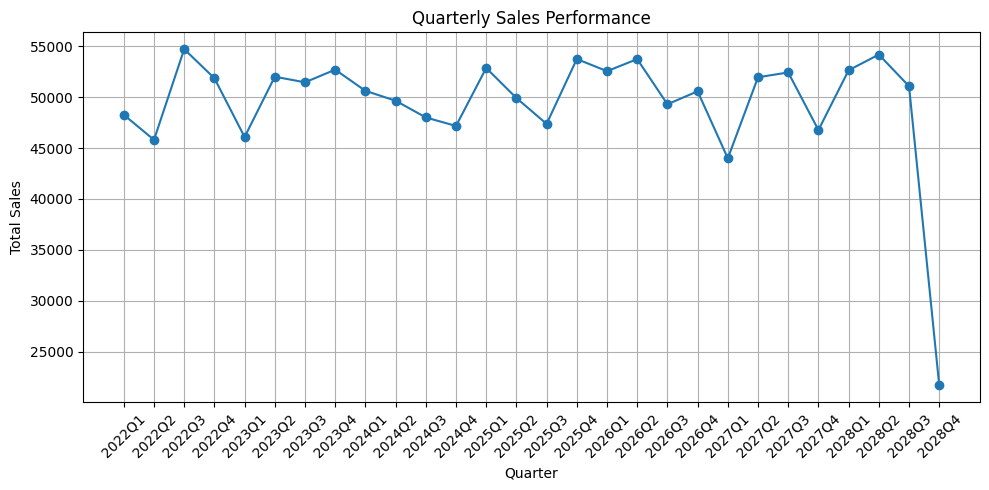


Observation:        Period  Total Sales
0  2022-03-31        48268
1  2022-06-30        45809
2  2022-09-30        54719
3  2022-12-31        51861
4  2023-03-31        46086
5  2023-06-30        52010
6  2023-09-30        51459
7  2023-12-31        52704
8  2024-03-31        50623
9  2024-06-30        49652
10 2024-09-30        48010
11 2024-12-31        47173
12 2025-03-31        52868
13 2025-06-30        49916
14 2025-09-30        47377
15 2025-12-31        53745
16 2026-03-31        52556
17 2026-06-30        53739
18 2026-09-30        49303
19 2026-12-31        50577
20 2027-03-31        43994
21 2027-06-30        51958
22 2027-09-30        52428
23 2027-12-31        46774
24 2028-03-31        52644
25 2028-06-30        54186
26 2028-09-30        51076
27 2028-12-31        21705
Thought:

> Entering new LLMChain chain...
Prompt after formatting:
Answer the following questions as best you can. You have access to the following tools:

sales_perf_monthly(query: str) - Summarizes sa

In [50]:
# COMBINED AGENT AND CONVERSATIONAL RETRIEVAL CHAIN

vector_store = load_or_rebuild_vector_store()

# To-Do - Move initialization to the best place
k_context_chunks = 4

# Create a retriever with desired parameters
retriever = vector_store.as_retriever(search_kwargs={"k": k_context_chunks})

# LLM initialized for the agent, at the agent code section

# Prompt for rephrasing (question condensing)
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template("""
    Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question.
    Chat History: {chat_history}
    Follow Up Input: {question}
    Standalone question:
""")

question_generator = LLMChain(
    llm=llm,
    prompt=CONDENSE_QUESTION_PROMPT,
# Notes - Use callbacks and verbosity on top-level chain (convo retrieval or agent),
#   unless debugging something specific.
# Don't replicate callbacks as now used for token volume metrics 
#    callbacks=[handler] # To-Do - Comment out when done
)

# Chain for answering using retrieved docs
combine_docs_chain = load_qa_chain(
    llm,
    output_key="output",
    chain_type="stuff"
)

# Build the ConversationalRetrievalChain
qa_chain = ConversationalRetrievalChain(
    retriever=retriever,
    memory=memory,
    output_key="output",
    question_generator=question_generator,
    combine_docs_chain=combine_docs_chain,
    return_source_documents=True,
    callbacks=rag_callbacks, # Used for callbacks and for token volume metrics
    verbose=True
)

while True:
    intent = "error"
    assistant_type = ""
    user_input = input("User: ")
    print("User:", user_input)
    if user_input.lower() == "exit":
        break

    intent = classify_input(user_input)
    print(f"[Classifier] Intent: {intent}")

    if intent == "greeting":
        response = "👋 Hi! I can help you analyze your sales data or answer BI-related questions."
    
    elif intent == "off_topic":
        response = "🔍 I’m focused on Business Intelligence and your data. Please ask me something related to that."

    elif intent == "unclear":
        response = "❓ I couldn’t understand your question. Can you rephrase it in the context of your business or data?"

    elif intent == "bi_query":
        assistant_type = " (RAG): "
        print("[Router] Routed to: RAG")
        print("Thinking...")
        print("Question: ", user_input)
        response = qa_chain.invoke({"question": user_input}, config={"callbacks": rag_callbacks})
        token_tracker["rag"].update(rag_oa_cb_handler)
        response = response["output"]
    
    elif intent in ["plot_request", "sales_analysis"]:
        assistant_type = " (Agent): "
        print("[Router] Routed to: Agent")
        print("Thinking...")
        adj_user_input = user_input
        if intent == "plot_request":
            adj_user_input = user_input + ". Ignore the plotting ask. Do not generate code for plotting."
        response = agent.invoke(adj_user_input, config={"callbacks": agent_callbacks})
        token_tracker["agent"].update(agent_oa_cb_handler)
        response = response["output"]
    elif not intent or intent == "error":
        assistant_type = " (Error): "
        response = "🥴 Something is wrong..."

    print("Assistant" + assistant_type + ":", response)

    print("📊 Session Token Summary:")
    print("Agent:", token_tracker["agent"])
    agent_token_cost = token_tracker["agent"].estimate_cost_usd('gpt-4o')
    print(f"Agent Token Cost (USD): ${agent_token_cost:.6f}")
    print("RAG:", token_tracker["rag"])
    rag_token_cost = token_tracker["rag"].estimate_cost_usd('gpt-4o')
    print(f"RAG Token Cost (USD): ${rag_token_cost:.6f}")
    total_tokens = token_tracker["agent"].total_tokens + token_tracker["rag"].total_tokens
    print("Total Tokens:", total_tokens)
    total_cost = agent_token_cost + rag_token_cost
    print(f"Total Cost (USD): ${total_cost:.6f}")


    # print("\nMemory:")
    # pretty_print(memory.chat_memory.messages)
    # print("\n")



# while True:
#     user_input = input("User: ")
#     print("User:", user_input)

#     if user_input.lower() == "exit":
#         break
#     elif check_greeting(user_input):
#         print("Greeting detected...")
#         response = (
#             "👋 Hi! I can help you analyze your sales data or answer BI questions. "
#             "Please ask me something specific about your data or business intelligence."
#         )
#     else:
#         route = route_query(user_input)
#         print(f"[Router] Routed to: {route}")
        
#         if route_query(user_input) == "rag":
#             print("Thinking...")
#             response = qa_chain.invoke({"question": user_input})
#             print("Assistant (RAG):", response["answer"])
#             response = response["answer"]
#         else:
#             print("Thinking...")
#             adj_user_input = user_input
#             if wants_plot(user_input):
#                 adj_user_input = user_input + ". Ignore the plotting ask. Do not generate code for plotting"
#             response = agent.invoke(adj_user_input)

#             print("Assistant (Agent):", response["output"])
#             response = response["output"]
    
    # To-Do - Probably need to manually manage message history, at least for the agent
    # st.session_state.messages.append({"role": "assistant", "content": response})
    # print("Assistant:", response)

# Testing strings
# Agent: Analyze sales data by month
# Agent with plotting: Analyze sales data by month and plot the results in a graph
# Agent with plotting: Analyze sales data, produce statistical metrics, and plot the data
# RAG: Explain the difference between OLAP and OLTP
# RAG: What is ETL in business intelligence?
# RAG: What are the limitations of IoT data for ML predictions?
# RAG: Summarize Walmart’s approach to customer segmentation
# RAG test set #2
# bi_query
#  or 
# sales_analysis
#  (depending on context)
# What preprocessing techniques are commonly applied to IoT time-series data?
# Describe a typical machine learning pipeline for sensor-based predictions
# How does concept drift affect time-series forecasting in dynamic environments?
# What model evaluation metrics are recommended for forecasting accuracy in BI dashboards?

# 🧮 
# Test Questions: Walmart Use Case
# Category: 
# bi_query
# How did Walmart optimize their logistics using big data analytics?
# What types of consumer behavior did Walmart analyze using sales data?
# Explain how Walmart implemented customer segmentation with predictive analytics

# 📊 
# Test Questions: Data Analysis & Plotting
# Category: 
# plot_request
# “Plot Walmart’s sales performance by year and product category.”
# “Can you show me a bar chart comparing quarterly sales from 2022 to 2024?”
# “Visualize the seasonal sales trends using time-series analysis.”

# HIGH LEVEL QUERIES - THEY WILL BREAK IT - TOO MANY TOKENS
# Apply time-series trend analysis to the sales data

# 🙅 
# Off-topic Control Questions
# Category: 
# off_topic
# “What’s your favorite BI tool?”
# Tell me a joke about AI
# Who is the CEO of OpenAI?

# CROSS-FUNCTIONAL TESTS - LINKING, MEMORY
# Good ones:
# What KPIs can we apply to monthly sales data?
# Calculate those KPIs using the monthly sales data


# What does the literature say about seasonal trends in retail sales?
# How does AI help identify customer segments in BI systems?
# “What is the impact of time-series forecasting in business intelligence?”
# How did Walmart leverage sales data for regional optimization?
# What role do KPIs play in evaluating business performance?

# 📊 Step 2: Follow-up with a Sales Data Question (memory test)
# Follow any of those with questions like:
# “Can you apply that to our sales data?”
# Show seasonal trends in our monthly performance.
# “Now segment the sales data by customer groups.”
# What KPIs can we derive from the last 12 months?
# “Analyze our regional sales fluctuations like in the Walmart case.”



In [59]:
from langchain.chat_models import ChatOpenAI
from langchain.evaluation.qa import QAEvalChain

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)

# Create the evaluation chain
eval_chain = QAEvalChain.from_llm(llm)

def run_evaluation(examples):
    """
    Run QA evaluation using LangChain's QAEvalChain.
    :param examples: List of dicts with keys 'query', 'reference', 'prediction'
    :return: List of evaluation results
    """
    references = [{"query": ex["query"], "answer": ex["reference"]} for ex in examples]
    predictions = [{"query": ex["query"], "result": ex["prediction"]} for ex in examples]
    return eval_chain.evaluate(examples=references, predictions=predictions)

/var/folders/vg/g9txtmts24scjl06gqs2q5p40000gp/T/ipykernel_5949/339742150.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4", temperature=0)


In [ ]:
# Evaluation test 1

examples = [
    {
        "query": "What is the difference between OLAP and OLTP?",
        "reference": "OLAP is used for analytical processing, OLTP for transactional processing.",
        "prediction": "OLTP is for fast transactions, OLAP is used for business analysis."
    },
    {
        "query": "What are the components of a BI system?",
        "reference": "Key components include data sources, ETL processes, data warehouse, OLAP tools, and dashboards.",
        "prediction": "A BI system includes ETL, OLAP, data warehouses, and visualization tools."
    },
    {
        "query": "How is OLTP different from OLAP?",
        "reference": "OLTP systems are optimized for transactional tasks; OLAP is used for complex queries and analysis.",
        "prediction": "OLAP is for quick transactions; OLTP is for analytics."  # ❌ Incorrect swap
    },
    {
        "query": "Explain ETL in business intelligence.",
        "reference": "ETL stands for Extract, Transform, Load — a process to move and prepare data for analysis.",
        "prediction": "ETL is the process of extracting, transforming, and loading data for analysis."
    },
    {
        "query": "List benefits of a BI platform.",
        "reference": "Improved decision-making, real-time insights, and data-driven culture.",
        "prediction": "BI platforms help improve decisions and offer real-time analytics."
    },
    {
        "query": "What is data governance in BI?",
        "reference": "Data governance ensures data quality, security, and compliance in BI systems.",
        "prediction": "Data governance is about making dashboards pretty."  # ❌ Incorrect
    },
    {
        "query": "What’s the purpose of a data warehouse?",
        "reference": "A centralized repository to store and manage data for analysis and reporting.",
        "prediction": "It’s a place where real-time transactions are processed."  # ❌ Confused with OLTP
    },
    {
        "query": "How can AI improve BI dashboards?",
        "reference": "AI can automate insights, personalize views, and detect anomalies in dashboards.",
        "prediction": "AI improves dashboards by analyzing and summarizing insights automatically."
    },
    {
        "query": "Describe a time-series analysis.",
        "reference": "It analyzes data points collected or recorded at specific time intervals.",
        "prediction": "It is used to analyze trends over time, often in monthly or quarterly formats."
    },
    {
        "query": "What is a KPI?",
        "reference": "A KPI is a Key Performance Indicator — a metric used to measure business success.",
        "prediction": "KPI means Key Performance Indicator, used to track business goals."
    },
    {
        "query": "How does Walmart use data analytics?",
        "reference": "Walmart uses analytics to optimize logistics, manage inventory, and personalize marketing.",
        "prediction": "Walmart uses AI for customer support only."  # ❌ Narrow/incomplete
    },
]

results = run_evaluation(examples)

import pandas as pd

df = pd.DataFrame([
    {
        "Question": ex["query"],
        "Expected Answer": ex["reference"],
        "Predicted Answer": ex["prediction"],
        "Grade": res.get("results", "N/A"),
        "Reason": res.get("reasoning", "No explanation")
    }
    for ex, res in zip(examples, results)
])

display(df)

In [ ]:
# Evaluation test with qa_chain preditions, not hardcoded examples

core_set = [
    {
        "query": "What is ETL in business intelligence?",
        "answer": "ETL stands for Extract, Transform, Load. It is the process of preparing data by extracting from sources, transforming it into a suitable format, and loading it into a data warehouse.",
        "prediction": None  # Will be filled during runtime
    },
    {
        "query": "What are the key metrics used in sales forecasting?",
        "answer": "Key metrics include historical sales data, seasonal trends, lead conversion rates, and average deal size.",
        "prediction": None
    },
    {
        "query": "How does big data analytics help in retail inventory management?",
        "answer": "It helps by predicting demand, optimizing stock levels, and reducing overstock or stockouts through real-time data.",
        "prediction": None
    },
    {
        "query": "What is a KPI dashboard used for?",
        "answer": "It visualizes key performance indicators to monitor business performance and support decision-making.",
        "prediction": None
    },
    {
        "query": "What is the difference between OLAP and OLTP?",
        "answer": "OLAP is used for analytical processing, OLTP for transactional processing.",
        "prediction": None
    }
]

rotation_set_1 = [
    {
        "query": "What are the components of a BI system?",
        "answer": "Key components include data sources, ETL processes, data warehouse, OLAP tools, and dashboards.",
        "prediction": None
    },
    {
        "query": "How is OLTP different from OLAP?",
        "answer": "OLTP systems are optimized for transactional tasks; OLAP is used for complex queries and analysis.",
        "prediction": None
    },
    {
        "query": "Explain ETL in business intelligence.",
        "answer": "ETL stands for Extract, Transform, Load — a process to move and prepare data for analysis.",
        "prediction": None
    },
    {
        "query": "List benefits of a BI platform.",
        "answer": "Improved decision-making, real-time insights, and data-driven culture.",
        "prediction": None
    },
    {
        "query": "What is data governance in BI?",
        "answer": "Data governance ensures data quality, security, and compliance in BI systems.",
        "prediction": None
    }
]

rotation_set_2 = [
    {
        "query": "What’s the purpose of a data warehouse?",
        "answer": "A centralized repository to store and manage data for analysis and reporting.",
        "prediction": None
    },
    {
        "query": "How can AI improve BI dashboards?",
        "answer": "AI can automate insights, personalize views, and detect anomalies in dashboards.",
        "prediction": None
    },
    {
        "query": "Describe a time-series analysis.",
        "answer": "It analyzes data points collected or recorded at specific time intervals.",
        "prediction": None
    },
    {
        "query": "What is a KPI?",
        "answer": "A KPI is a Key Performance Indicator — a metric used to measure business success.",
        "prediction": None
    },
    {
        "query": "How does Walmart use data analytics?",
        "answer": "Walmart uses analytics to optimize logistics, manage inventory, and personalize marketing.",
        "prediction": None
    }
]

# Collect all sets into a dictionary
qa_sets = {
    "core": core_set,
    "rotation_1": rotation_set_1,
    "rotation_2": rotation_set_2
}

In [61]:
active_eval_set = qa_sets["core"]

In [62]:
pretty_print(active_eval_set)

[ { 'answer': 'ETL stands for Extract, Transform, Load. It is the process of preparing data by '
              'extracting from sources, transforming it into a suitable format, and loading it '
              'into a data warehouse.',
    'prediction': None,
    'query': 'What is ETL in business intelligence?'},
  { 'answer': 'Key metrics include historical sales data, seasonal trends, lead conversion rates, '
              'and average deal size.',
    'prediction': None,
    'query': 'What are the key metrics used in sales forecasting?'},
  { 'answer': 'It helps by predicting demand, optimizing stock levels, and reducing overstock or '
              'stockouts through real-time data.',
    'prediction': None,
    'query': 'How does big data analytics help in retail inventory management?'},
  { 'answer': 'It visualizes key performance indicators to monitor business performance and '
              'support decision-making.',
    'prediction': None,
    'query': 'What is a KPI dashboard 

In [63]:
for example in active_eval_set:
    prediction = qa_chain.invoke({"question": example["query"]})["output"]
    example["prediction"] = prediction



> Entering new ConversationalRetrievalChain chain...

> Finished chain.


> Entering new ConversationalRetrievalChain chain...

> Finished chain.


> Entering new ConversationalRetrievalChain chain...

> Finished chain.


> Entering new ConversationalRetrievalChain chain...

> Finished chain.


> Entering new ConversationalRetrievalChain chain...

> Finished chain.


In [64]:
pretty_print(active_eval_set)

[ { 'answer': 'ETL stands for Extract, Transform, Load. It is the process of preparing data by '
              'extracting from sources, transforming it into a suitable format, and loading it '
              'into a data warehouse.',
    'prediction': 'ETL stands for Extract, Transform, Load. In the context of business '
                  'intelligence, ETL is a crucial process in data processing that involves:\n'
                  '\n'
                  '1. **Extracting** data from various sources, which can include databases, cloud '
                  'storage, or other data repositories.\n'
                  '2. **Transforming** the data into a suitable format or structure for analysis. '
                  'This step may involve cleaning the data, aggregating it, and applying business '
                  'rules to ensure consistency and accuracy.\n'
                  '3. **Loading** the transformed data into a data warehouse or other data storage '
                  'systems where i

In [65]:
def run_evaluation(sample_size=None):
    print("📊 Evaluating active set...")

    examples = active_eval_set
    if not examples:
        print("⚠️ No examples found in active_eval_set.")
        return []

    if sample_size:
        examples = random.sample(examples, min(sample_size, len(examples)))

    # Prepare predictions and references
    predictions = [{"query": ex["query"], "result": ex.get("prediction", ex["answer"])} for ex in examples]
    references = [{"query": ex["query"], "answer": ex["answer"]} for ex in examples]

    # Run evaluation
    graded_outputs = eval_chain.evaluate(examples=references, predictions=predictions)

    # Display results
    for i, result in enumerate(graded_outputs):
        print(f"\n🔹 Q: {examples[i]['query']}")
        print(f"✅ A: {examples[i]['answer']}")
        print(f"🤖 P: {predictions[i]['result']}")
        print(f"🧠 Grade: {result.get('results')}")
        print(f"📝 Explanation: {result.get('reasoning', 'N/A')}")

    return graded_outputs

In [66]:
eval_results = run_evaluation()

📊 Evaluating active set...

🔹 Q: What is ETL in business intelligence?
✅ A: ETL stands for Extract, Transform, Load. It is the process of preparing data by extracting from sources, transforming it into a suitable format, and loading it into a data warehouse.
🤖 P: ETL stands for Extract, Transform, Load. In the context of business intelligence, ETL is a crucial process in data processing that involves:

1. **Extracting** data from various sources, which can include databases, cloud storage, or other data repositories.
2. **Transforming** the data into a suitable format or structure for analysis. This step may involve cleaning the data, aggregating it, and applying business rules to ensure consistency and accuracy.
3. **Loading** the transformed data into a data warehouse or other data storage systems where it can be accessed for analysis and reporting.

ETL is essential for integrating data from different sources and preparing it for use in business intelligence applications, enabling o

In [67]:
import matplotlib.pyplot as plt

def plot_eval_results(results):
    counts = {"CORRECT": 0, "INCORRECT": 0, "Other": 0}
    for res in results:
        grade = res.get("results", "").upper()
        if grade in counts:
            counts[grade] += 1
        else:
            counts["Other"] += 1

    plt.bar(counts.keys(), counts.values(), color=["green", "red", "gray"])
    plt.title("QAEvalChain Results")
    plt.ylabel("Count")
    plt.show()

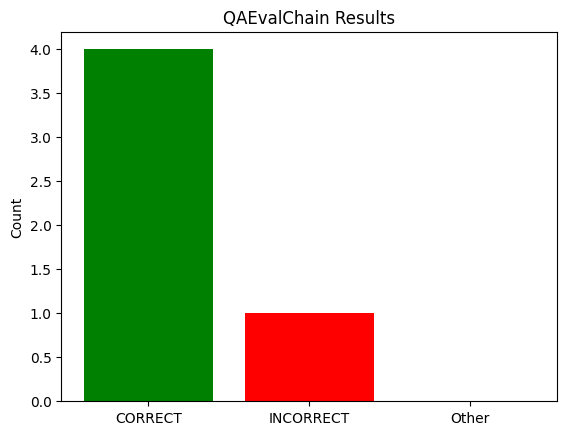

In [68]:
plot_eval_results(eval_results)

In [ ]:
# from langchain.callbacks import OpenAICallbackHandler

# token_tracker = OpenAICallbackHandler()
# session_total_tokens = 0

# with token_tracker as cb:
#     response = qa_chain.invoke({"question": standalone_question})

#     # Access token metrics
#     input_tokens = cb.prompt_tokens
#     output_tokens = cb.completion_tokens
#     total_tokens = cb.total_tokens

#     session_total_tokens += total_tokens

# print("🧮 Tokens - Input:", input_tokens, 
#       "| Output:", output_tokens, 
#       "| Total:", total_tokens, 
#       "| Cumulative:", session_total_tokens)

In [ ]:
# from langchain_core.messages import get_buffer_string

# while True:
#     user_input = input("User: ")
#     if user_input.lower() == "exit":
#         break

#     # Step 1: Load chat history as string
#     chat_history_str = get_buffer_string(memory.chat_memory.messages)

#     # Step 2: Generate the standalone question manually
#     standalone_result = question_generator.invoke({
#         "question": user_input,
#         "chat_history": chat_history_str
#     })
#     standalone_question = standalone_result["text"]  # Key may be 'text' or 'output' depending on the version

#     # Step 3: Print or log the reformulated question
#     print("🔁 Reformulated question:", standalone_question)

#     # Step 4: Proceed with the QA chain using the reformulated question
#     response = qa_chain.invoke({"question": standalone_question})
#     print("📘 Assistant (RAG):", response["output"])

In [ ]:
# print(memory.load_memory_variables({}))

In [ ]:
# mem_dump = memory.load_memory_variables({})
# print(type(mem_dump["chat_history"]))
# print(mem_dump["chat_history"])

In [ ]:
# new_q = question_generator.run({
#     "question": "What preprocessing techniques are commonly applied to IoT time-series data?",
#     "chat_history": mem_dump["chat_history"]
# })

# print(new_q)